In [1]:
# 引入依赖库
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn import preprocessing
from models import *
from utils import *
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import os

/root/miniconda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
# 必要参数定义
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 训练设备,如果NVIDIA GPU已配置，会自动使用GPU训练
train_ratio = 0.8  # 训练集比例
val_ratio = 0.1  # 验证集比例
test_ratio = 0.1  # 测试集比例
batch_size = 64  # 批大小，若用CPU，建议为1
input_length = 4  # 每个batch的输入数据长度
output_length = 1  # 每个batch的输出数据长度，1为单步预测
loss_function = 'MSE'  # 损失函数定义
learning_rate = 0.001  # 基础学习率
weight_decay = 0.001  # 权重衰减系数
num_blocks = 3 # lstm堆叠次数
dim = 512  # 隐层维度
interval_length = 55000  # 预测数据长度，最长不可以超过总数据条数
scalar = True  # 是否使用归一化
scalar_contain_labels = True  # 归一化过程是否包含目标值的历史数据
target_value = 'Temperature (C)'  # 需要预测的列名，可以在excel中查看
# 多步，单步标签 #这里有个小问题只能实现单步不用改这个
if output_length > 1:
    forecasting_model = 'multi_steps'
else:
    forecasting_model = 'one_steps'

In [3]:
csv_path = "./weatherHistory.csv"
df = pd.read_csv(csv_path)

In [4]:
# 原始数据集存在重复项，要进行去重
df.drop_duplicates(subset=["date"],keep='first',inplace=True)

In [5]:
# checking null values in our dataset
df.isna().sum()

date                        0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Pressure (millibars)        0
dtype: int64

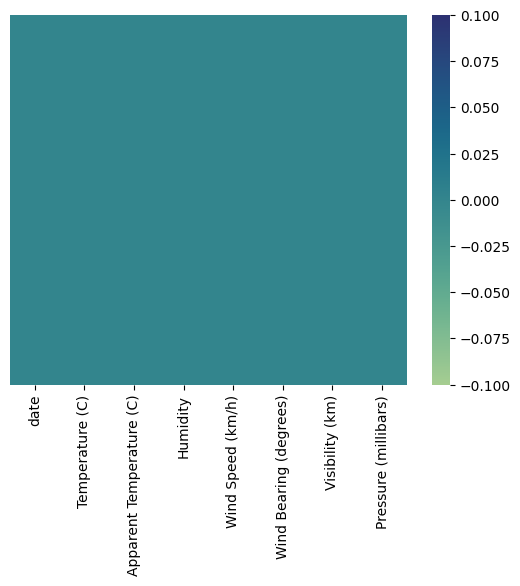

In [6]:
import seaborn as sns
sns.heatmap(df.isna(),yticklabels=False,cmap='crest')
plt.show()

In [7]:
# checking null values in our dataset
df.isna().sum()

date                        0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Pressure (millibars)        0
dtype: int64

In [8]:
df_1=df.copy()

In [9]:
# getting the datatypes of all the columns having null values
# first storing all the column names in a list having null values
col = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
       'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)']
df = df[col]
df[col].dtypes

Temperature (C)             float64
Apparent Temperature (C)    float64
Humidity                    float64
Wind Speed (km/h)           float64
Wind Bearing (degrees)        int64
Visibility (km)             float64
Pressure (millibars)        float64
dtype: object

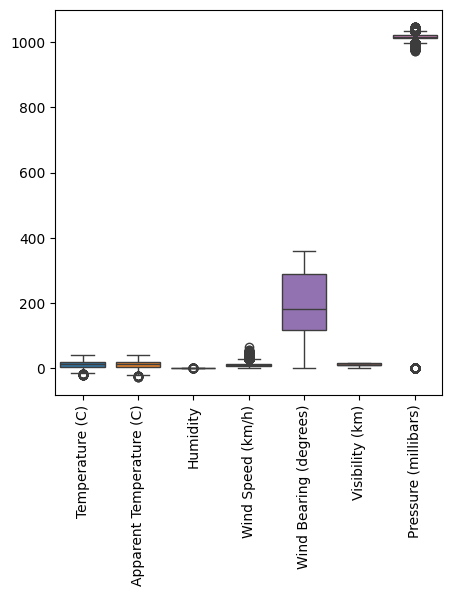

In [10]:
# plotting a boxplot
plt.figure(figsize=(5,5))
sns.boxplot(data=df)
plt.xticks(rotation='vertical')
plt.show()

In [11]:
# getting the quartile one and quartile 3 values of each column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
# finally calculating the interquartile range IQR
IQR = Q3 - Q1

In [12]:
# if the values fall behind Q1 - (1.5 * IQR) or above Q3 + 1.5*IQR,
#then it is been defined as outlier
((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()

Temperature (C)               44
Apparent Temperature (C)      22
Humidity                      46
Wind Speed (km/h)           3020
Wind Bearing (degrees)         0
Visibility (km)                0
Pressure (millibars)        4400
dtype: int64

In [13]:
mask = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
mask

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
96448,False,False,False,False,False,False,False
96449,False,False,False,False,False,False,False
96450,False,False,False,False,False,False,False
96451,False,False,False,False,False,False,False


In [14]:
for i in mask.columns:
    df[i].astype('float')
    temp = df[i].median()
    df.loc[mask[i], i] = temp

In [15]:
# outliers are now being handled and are replaced with that column's median value
((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()

Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Pressure (millibars)        0
dtype: int64

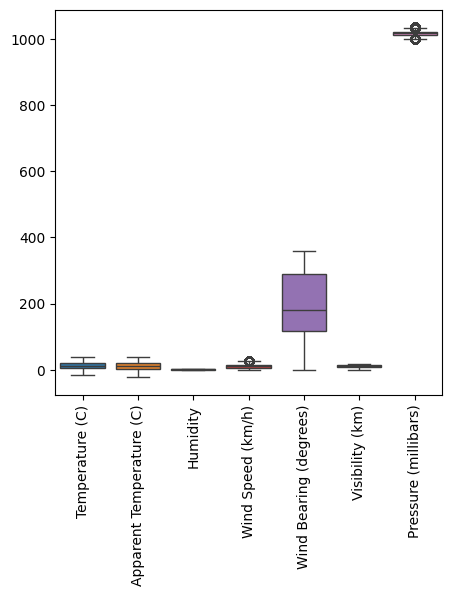

In [16]:
plt.figure(figsize=(5,5))
sns.boxplot(data=df)
plt.xticks(rotation='vertical')
plt.show()

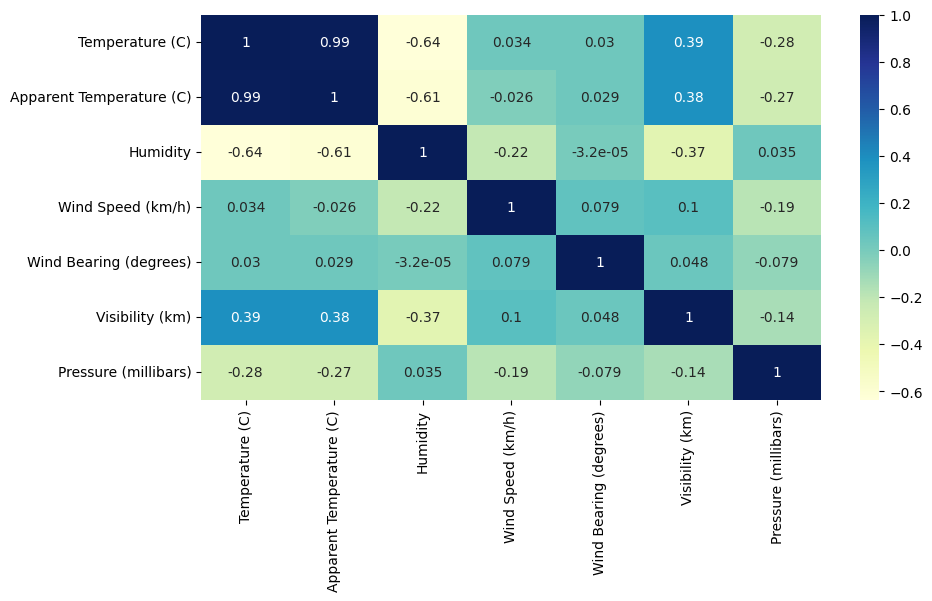

In [17]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(),cmap='YlGnBu',annot=True)
plt.show()

In [18]:
feature_keys = [
    'Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
       'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)'
]

date_time_key = "date"

In [19]:
df = pd.concat([df_1['date'], df], axis=1)

In [20]:
print(df.head())

                            date  Temperature (C)  Apparent Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200         9.472222                  7.388889   
1  2006-04-01 01:00:00.000 +0200         9.355556                  7.227778   
2  2006-04-01 02:00:00.000 +0200         9.377778                  9.377778   
3  2006-04-01 03:00:00.000 +0200         8.288889                  5.944444   
4  2006-04-01 04:00:00.000 +0200         8.755556                  6.977778   

   Humidity  Wind Speed (km/h)  Wind Bearing (degrees)  Visibility (km)  \
0      0.89            14.1197                     251          15.8263   
1      0.86            14.2646                     259          15.8263   
2      0.89             3.9284                     204          14.9569   
3      0.83            14.1036                     269          15.8263   
4      0.83            11.0446                     259          15.8263   

   Pressure (millibars)  
0               1015.13  
1               1015.6

In [21]:
features = df[feature_keys]
features.index = df[date_time_key]
features.head()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
date,,,,,,,
2006-04-01 00:00:00.000 +0200,9.472222,7.388889,0.89,14.1197,251,15.8263,1015.13
2006-04-01 01:00:00.000 +0200,9.355556,7.227778,0.86,14.2646,259,15.8263,1015.63
2006-04-01 02:00:00.000 +0200,9.377778,9.377778,0.89,3.9284,204,14.9569,1015.94
2006-04-01 03:00:00.000 +0200,8.288889,5.944444,0.83,14.1036,269,15.8263,1016.41
2006-04-01 04:00:00.000 +0200,8.755556,6.977778,0.83,11.0446,259,15.8263,1016.51


In [22]:
df['Date Time'] = pd.to_datetime(df['date'])  # 确保时间列是日期时间格式
df.set_index('Date Time', inplace=True)  # 将时间列设为索引


# 选择目标列和观察列
target = df['Temperature (C)']
observed_cov = df[['Apparent Temperature (C)', 'Humidity',
       'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)']]

In [23]:
selected_columns = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
       'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)']

In [24]:
df_1=df[selected_columns]
df_1.head()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
Date Time,,,,,,,
2006-04-01 00:00:00+02:00,9.472222,7.388889,0.89,14.1197,251,15.8263,1015.13
2006-04-01 01:00:00+02:00,9.355556,7.227778,0.86,14.2646,259,15.8263,1015.63
2006-04-01 02:00:00+02:00,9.377778,9.377778,0.89,3.9284,204,14.9569,1015.94
2006-04-01 03:00:00+02:00,8.288889,5.944444,0.83,14.1036,269,15.8263,1016.41
2006-04-01 04:00:00+02:00,8.755556,6.977778,0.83,11.0446,259,15.8263,1016.51


In [25]:
#  读取数据
df = df_1[:interval_length]
features_num = 7  # 请手动输入特征维度数量
if features_num > 1:
    features_ = df.values
else:
    features_ = df[target_value].values
labels_ = df[target_value].values
# 初步划分训练集、验证集、测试集
split_train_val, split_val_test = int(len(features_)*train_ratio),                                  int(len(features_)*train_ratio)+int(len(features_)*val_ratio)

In [26]:
#  数据标准化
if scalar:
    #min-max scalar
    train_features_ = features_[:split_train_val]
    val_test_features_ = features_[split_train_val:]
    scalar = preprocessing.MinMaxScaler()
    if features_num == 1:
        train_features_ = np.expand_dims(train_features_, axis=1)
        val_test_features_ = np.expand_dims(val_test_features_, axis=1)
    train_features_ = scalar.fit_transform(train_features_)
    val_test_features_ = scalar.transform(val_test_features_)
    # 重新将数据进行拼接
    features_ = np.vstack([train_features_, val_test_features_])
    if scalar_contain_labels:
        labels_ = features_[:, -1]

if len(features_.shape) == 1:
    features_ = np.expand_dims(features_,0).T
features, labels = get_rolling_window_multistep(output_length, 0, input_length,
                                                features_.T, np.expand_dims(labels_, 0))

data preparing: 100%|██████████| 54996/54996 [00:48<00:00, 1133.75it/s]


In [27]:
#  构建数据集
labels = torch.squeeze(labels, dim=1)
features = features.to(torch.float32)
labels = labels.to(torch.float32)
split_train_val, split_val_test = int(len(features)*train_ratio), int(len(features)*train_ratio)+int(len(features)*val_ratio)
train_features, train_labels = features[:split_train_val], labels[:split_train_val]
val_features, val_labels = features[split_train_val:split_val_test], labels[split_train_val:split_val_test]
test_features, test_labels = features[split_val_test:], labels[split_val_test:]

In [28]:
#  数据管道构建，此处采用torch高阶API
train_Datasets = TensorDataset(train_features.to(device), train_labels.to(device))
train_Loader = DataLoader(batch_size=batch_size, dataset=train_Datasets)
val_Datasets = TensorDataset(val_features.to(device), val_labels.to(device))
val_Loader = DataLoader(batch_size=batch_size, dataset=val_Datasets)
test_Datasets = TensorDataset(test_features.to(device), test_labels.to(device))
test_Loader = DataLoader(batch_size=batch_size, dataset=test_Datasets)

In [29]:
#  模型定义
model = LSTMMain(input_size=features_num, output_len=output_length,
                                  lstm_hidden=dim, lstm_layers=num_blocks, batch_size=batch_size, device=device)

model.to(device)
if loss_function == 'MSE':
    loss_func = nn.MSELoss(reduction='mean')

In [30]:
#  训练代数定义
epochs = 25
#  优化器定义，学习率衰减定义
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs//3, eta_min=0.00001)

In [31]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import r2_score

# Lists to store MAE, RMSE, and R² for each epoch
train_mae_history = []
train_rmse_history = []
train_r2_history = []
val_mae_history = []
val_rmse_history = []
val_r2_history = []

print("——————————————————————Training Starts——————————————————————")
torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    # Training
    model.train()
    train_loss_sum = 0
    train_mae_sum = 0
    train_rmse_sum = 0
    all_train_preds = []
    all_train_labels = []
    for step, (feature_, label_) in enumerate(train_Loader):
        optimizer.zero_grad()
        feature_ = feature_.permute(0, 2, 1)
        prediction = model(feature_)
        loss = loss_func(prediction, label_)
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)
        optimizer.step()
        train_loss_sum += loss.item()
        
        # Store predictions and labels for R² calculation
        all_train_preds.append(prediction.detach().cpu().numpy())
        all_train_labels.append(label_.detach().cpu().numpy())
        
        # Calculate MAE and RMSE for this batch
        mae = torch.mean(torch.abs(prediction - label_)).item()
        rmse = torch.sqrt(torch.mean((prediction - label_) ** 2)).item()
        train_mae_sum += mae
        train_rmse_sum += rmse

    # Calculate R² for training data for the entire epoch
    all_train_preds = np.concatenate(all_train_preds)
    all_train_labels = np.concatenate(all_train_labels)
    train_r2 = r2_score(all_train_labels, all_train_preds)
    
    # Record each epoch's metrics
    train_mae_history.append(train_mae_sum / (step + 1))  # Average MAE per epoch
    train_rmse_history.append(train_rmse_sum / (step + 1))  # Average RMSE per epoch
    train_r2_history.append(train_r2)

    print(f"Epoch {epoch}: Train Loss = {train_loss_sum:.4f}, Train MAE = {train_mae_history[-1]:.4f}, Train RMSE = {train_rmse_history[-1]:.4f}, Train R² = {train_r2:.4f}")

    # Validation
    model.eval()
    val_loss_sum = 0
    val_mae_sum = 0
    val_rmse_sum = 0
    all_val_preds = []
    all_val_labels = []
    for val_step, (feature_, label_) in enumerate(val_Loader):
        feature_ = feature_.permute(0, 2, 1)
        with torch.no_grad():
            prediction = model(feature_)
            val_loss = loss_func(prediction, label_)
        val_loss_sum += val_loss.item()
        
        # Store predictions and labels for R² calculation
        all_val_preds.append(prediction.cpu().numpy())
        all_val_labels.append(label_.cpu().numpy())
        
        # Calculate MAE and RMSE for this batch
        mae = torch.mean(torch.abs(prediction - label_)).item()
        rmse = torch.sqrt(torch.mean((prediction - label_) ** 2)).item()
        val_mae_sum += mae
        val_rmse_sum += rmse

    # Calculate R² for validation data for the entire epoch
    all_val_preds = np.concatenate(all_val_preds)
    all_val_labels = np.concatenate(all_val_labels)
    val_r2 = r2_score(all_val_labels, all_val_preds)
    
    # Record each epoch's metrics
    val_mae_history.append(val_mae_sum / (val_step + 1))  # Average MAE per epoch
    val_rmse_history.append(val_rmse_sum / (val_step + 1))  # Average RMSE per epoch
    val_r2_history.append(val_r2)

    print(f"Epoch {epoch}: Val Loss = {val_loss_sum:.4f}, Val MAE = {val_mae_history[-1]:.4f}, Val RMSE = {val_rmse_history[-1]:.4f}, Val R² = {val_r2:.4f}")

    # Save best model
    if epoch == 0 or val_loss_sum < val_best:
        val_best = val_loss_sum
        #torch.save(model.state_dict(), './TCN_LSTM_KAN/TCN_LSTM_KAN_best')  # Save best weights
        print("val_best change")
    '''
    # Save model every 10 epochs
    if epoch % 10 == 0 and epoch >= 10:
        torch.save(model.state_dict(), f'./TCN_LSTM_KAN/TCN_LSTM_KAN_epoch_{epoch}.pth')
        print(f"Model saved at epoch {epoch}")
    '''

print("best val loss = " + str(val_best))
print("——————————————————————Training Ends——————————————————————")


——————————————————————Training Starts——————————————————————


/tmp/ipykernel_15664/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 0: Train Loss = 11.0317, Train MAE = 0.0801, Train RMSE = 0.0975, Train R² = 0.5072
Epoch 0: Val Loss = 0.2310, Val MAE = 0.0331, Val RMSE = 0.0463, Val R² = 0.9113
val_best change


/tmp/ipykernel_15664/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 1: Train Loss = 2.3135, Train MAE = 0.0331, Train RMSE = 0.0505, Train R² = 0.8967
Epoch 1: Val Loss = 0.2102, Val MAE = 0.0308, Val RMSE = 0.0443, Val R² = 0.9192
val_best change


/tmp/ipykernel_15664/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 2: Train Loss = 2.3973, Train MAE = 0.0347, Train RMSE = 0.0516, Train R² = 0.8929
Epoch 2: Val Loss = 0.2015, Val MAE = 0.0297, Val RMSE = 0.0430, Val R² = 0.9226
val_best change


/tmp/ipykernel_15664/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 4: Train Loss = 2.1722, Train MAE = 0.0310, Train RMSE = 0.0485, Train R² = 0.9030
Epoch 4: Val Loss = 0.1709, Val MAE = 0.0247, Val RMSE = 0.0390, Val R² = 0.9343
val_best change


/tmp/ipykernel_15664/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 5: Train Loss = 2.0963, Train MAE = 0.0297, Train RMSE = 0.0475, Train R² = 0.9064
Epoch 5: Val Loss = 0.1549, Val MAE = 0.0210, Val RMSE = 0.0365, Val R² = 0.9405
val_best change


/tmp/ipykernel_15664/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 9: Train Loss = 1.9982, Train MAE = 0.0277, Train RMSE = 0.0459, Train R² = 0.9108
Epoch 9: Val Loss = 0.1545, Val MAE = 0.0208, Val RMSE = 0.0363, Val R² = 0.9406


/tmp/ipykernel_15664/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 10: Train Loss = 1.9835, Train MAE = 0.0274, Train RMSE = 0.0456, Train R² = 0.9114
Epoch 10: Val Loss = 0.1517, Val MAE = 0.0202, Val RMSE = 0.0357, Val R² = 0.9417
val_best change


/tmp/ipykernel_15664/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 11: Train Loss = 1.9599, Train MAE = 0.0270, Train RMSE = 0.0453, Train R² = 0.9125
Epoch 11: Val Loss = 0.1522, Val MAE = 0.0203, Val RMSE = 0.0359, Val R² = 0.9415


/tmp/ipykernel_15664/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 12: Train Loss = 1.9566, Train MAE = 0.0269, Train RMSE = 0.0452, Train R² = 0.9126
Epoch 12: Val Loss = 0.1511, Val MAE = 0.0197, Val RMSE = 0.0356, Val R² = 0.9419
val_best change


/tmp/ipykernel_15664/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


KeyboardInterrupt: 

In [34]:
np.savez('./asb_icb_metrics_history.npz', 
         train_mae=train_mae_history, 
         train_rmse=train_rmse_history, 
         train_r2=train_r2_history, 
         val_mae=val_mae_history, 
         val_rmse=val_rmse_history, 
         val_r2=val_r2_history)

In [31]:
import matplotlib.pyplot as plt

# 训练及验证循环
train_loss_history = []
val_loss_history = []

print("——————————————————————Training Starts——————————————————————")
torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    # 训练
    LSTMMain_model.train()
    train_loss_sum = 0
    step = 1
    for step, (feature_, label_) in enumerate(train_Loader):
        optimizer.zero_grad()
        feature_ = feature_.permute(0, 2, 1)
        prediction = LSTMMain_model(feature_)
        loss = loss_func(prediction, label_)
        loss.backward()
        torch.nn.utils.clip_grad_norm(LSTMMain_model.parameters(), 0.15)
        optimizer.step()
        train_loss_sum += loss.item()

    # 记录每个 epoch 的训练损失
    train_loss_history.append(train_loss_sum)

    print("epochs = " + str(epoch))
    print('train_loss = ' + str(train_loss_sum))

    # 验证
    LSTMMain_model.eval()
    val_loss_sum = 0
    val_step = 1
    for val_step, (feature_, label_) in enumerate(val_Loader):
        feature_ = feature_.permute(0, 2, 1)
        with torch.no_grad():
            prediction = LSTMMain_model(feature_)
            val_loss = loss_func(prediction, label_)
        val_loss_sum += val_loss.item()

    # 记录每个 epoch 的验证损失
    val_loss_history.append(val_loss_sum)

    print('val_loss = ' + str(val_loss_sum))

    if epoch == 0:
        val_best = val_loss_sum
    else:
        if val_best > val_loss_sum:
            val_best = val_loss_sum
            torch.save(LSTMMain_model.state_dict(), './lstm_asb_icb_dcattention_0001/asb_icb_best')  # 保存最好权重
            print("val_best change")

    # 每隔10个epoch保存一次模型
    if epoch % 1 == 0 and epoch>=29:
        torch.save(LSTMMain_model.state_dict(), f'./lstm_asb_icb_dcattention_0001/asb_icb_epoch_{epoch}.pth')
        print(f"Model saved at epoch {epoch}")

print("best val loss = " + str(val_best))
print("——————————————————————Training Ends——————————————————————")

——————————————————————Training Starts——————————————————————


/tmp/ipykernel_11952/2655027825.py:20: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(LSTMMain_model.parameters(), 0.15)


KeyboardInterrupt: 

In [31]:
#  测试集预测
LSTMMain_model.load_state_dict(torch.load('./lstm_asb_icb_dcattention_0001/asb_icb_epoch_47.pth'))  # 调用权重
test_loss_sum = 0
#  测试集inference
print("——————————————————————Testing Starts——————————————————————")
for step, (feature_, label_) in enumerate(test_Loader):
    feature_ = feature_.permute(0, 2, 1)
    with torch.no_grad():
         if step ==0:
            prediction = LSTMMain_model(feature_)
            pre_array = prediction.cpu()
            label_array = label_.cpu()
            loss = loss_func(prediction, label_)
            test_loss_sum += loss.item()
         else:
            prediction = LSTMMain_model(feature_)
            pre_array = np.vstack((pre_array, prediction.cpu()))
            label_array = np.vstack((label_array, label_.cpu()))
            loss = loss_func(prediction, label_)
            test_loss_sum += loss.item()
print("test loss = " + str(test_loss_sum))
print("——————————————————————Testing Ends——————————————————————")

——————————————————————Testing Starts——————————————————————
test loss = 0.20721206652251567
——————————————————————Testing Ends——————————————————————


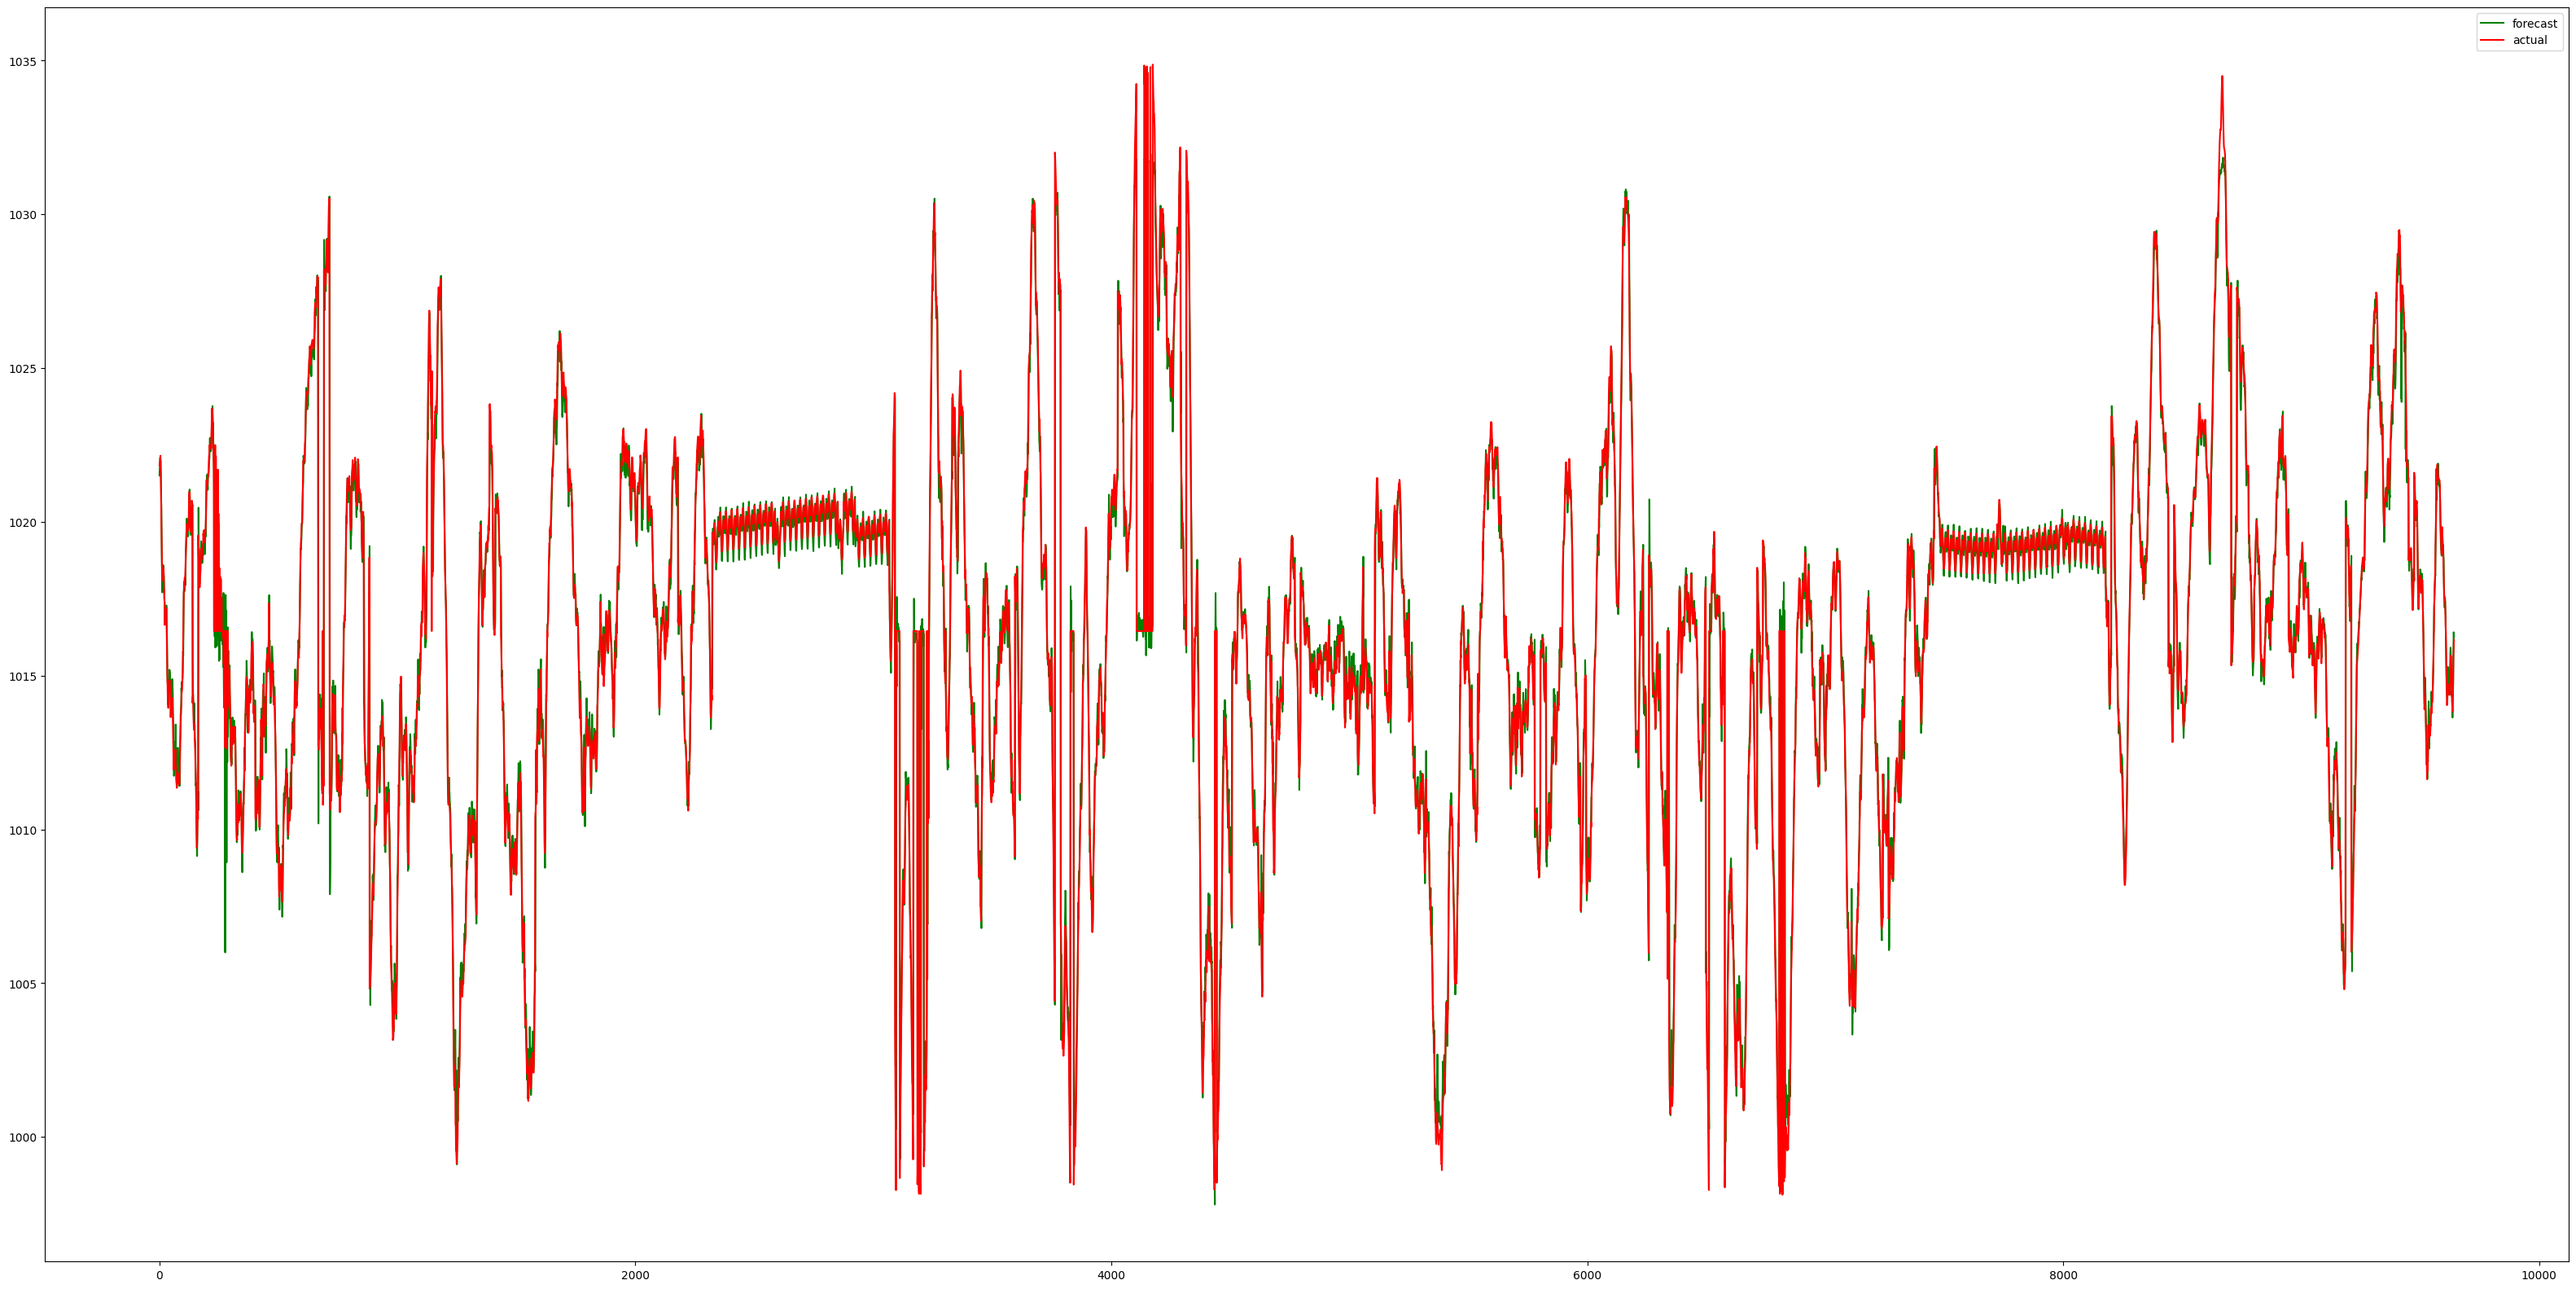

MSE score = 1.8571691754737891
MAE score = 0.44362765470794024
RMSE score = 1.362779943891819
MAPE score = 0.00043698734700810667
R² = 0.9487166201188366


In [32]:
###### print("——————————————————————Post-Processing——————————————————————")
if scalar_contain_labels and scalar:
    pre_inverse = []
    test_inverse = []
    if features_num == 1 and output_length == 1:
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(np.expand_dims(pre_array[pre_slice,:], axis=1))
            test_inverse_slice = scalar.inverse_transform(np.expand_dims(label_array[pre_slice,:], axis=1))
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse).squeeze(axis=-1)
        test_labels = np.array(test_inverse).squeeze(axis=-1)
    elif features_num > 1:
        if isinstance(pre_array, np.ndarray):
            pre_array = torch.from_numpy(pre_array)  # 确保 pre_array 是 torch.Tensor
        if isinstance(test_labels, np.ndarray):
            test_labels = torch.from_numpy(test_labels)  # 转换 test_labels 为 torch.Tensor
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(torch.cat((torch.zeros(pre_array[0].shape[0], features_num-1), torch.unsqueeze(pre_array[pre_slice], dim=1)), 1))[:,-1]
            test_inverse_slice = scalar.inverse_transform(torch.cat((torch.zeros(test_labels[0].shape[0], features_num-1), torch.unsqueeze(test_labels[pre_slice], dim=1)), 1))[:,-1]
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse)
        test_labels = np.array(test_inverse)
    else:
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(np.expand_dims(pre_array[pre_slice,:], axis=1))
            test_inverse_slice = scalar.inverse_transform(np.expand_dims(label_array[pre_slice,:], axis=1))
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse).squeeze(axis=-1)
        test_labels = np.array(test_inverse).squeeze(axis=-1)

    plt.figure(figsize=(40,20))
    if forecasting_model == 'multi_steps':
        plt.plot(pre_array[0], 'g')
        plt.plot(test_labels[0], "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    else:
        plt.plot(pre_array, 'g')
        plt.plot(test_labels, "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()

    # 计算衡量指标
    MSE_l = mean_squared_error(test_labels, pre_array)
    MAE_l = mean_absolute_error(test_labels, pre_array)
    RMSE_l = MSE_l ** 0.5  # RMSE 计算
    MAPE_l = mean_absolute_percentage_error(test_labels, pre_array)
    R2 = r2_score(test_labels, pre_array)
    
    print('MSE score = %s' % MSE_l)
    print('MAE score = %s' % MAE_l)
    print('RMSE score = %s' % RMSE_l)
    print('MAPE score = %s' % MAPE_l)
    print('R² = %s' % R2)

else:
    plt.figure(figsize=(40,20))
    if forecasting_model == 'multi_steps':
        plt.plot(pre_array[0], 'g')
        plt.plot(test_labels[0].cpu(), "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    else:
        plt.plot(pre_array, 'g')
        plt.plot(test_labels.cpu(), "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()

    MSE_l = mean_squared_error(test_labels.cpu(), pre_array)
    MAE_l = mean_absolute_error(test_labels.cpu(), pre_array)
    RMSE_l = MSE_l ** 0.5  # RMSE 计算
    MAPE_l = mean_absolute_percentage_error(test_labels.cpu(), pre_array)
    R2 = r2_score(test_labels.cpu(), pre_array)
    
    print('MSE score = %s' % MSE_l)
    print('MAE score = %s' % MAE_l)
    print('RMSE score = %s' % RMSE_l)
    print('MAPE score = %s' % MAPE_l)
    print('R² = %s' % R2)